# The 2-dim *Donut* example fitted at given points

*last tested with bayesfast commit 5810931*

In [1]:
import numpy as np
import bayesfast as bf
from threadpoolctl import threadpool_limits
threadpool_limits(1) # TODO: implement a bayesfast global thread controller

single_ring = np.concatenate((
    np.cos(np.pi * np.arange(0, 2, 0.25))[:, np.newaxis],
    np.sin(np.pi * np.arange(0, 2, 0.25))[:, np.newaxis]), axis=-1)
double_ring = np.concatenate((4 * single_ring, 5 * single_ring))

In [2]:
a = 5
b = 0.5

def f_0(x):
    return np.linalg.norm(x, 2, -1)

def j_0(x):
    '''not actually used'''
    foo = x / np.linalg.norm(x, 2, -1)
    return foo if np.all(np.isfinite(foo)) else np.ones_like(foo)

def f_1(x):
    return -(x - a)**2 / b

def j_1(x):
    return -2 * (x - a) / b

In [3]:
bf.utils.random.set_generator(2) # set up the global random number generator
bf.utils.parallel.set_backend(8) # set up the global parallel backend

module_0 = bf.Module(fun=f_0, input_vars='x', output_vars='m')
module_1 = bf.Module(fun=f_1, jac=j_1, input_vars='m', output_vars='logp')

density_0 = bf.Density(module_list=[module_0, module_1], input_shapes=[2],
                       input_vars='x', density_name='logp')
density_0.set_decay_options(use_decay=True)

# surro_0 = bf.modules.PolyModel('linear', input_size=2, output_size=1,
#                                input_vars='x', output_vars='m')
surro_1 = bf.modules.PolyModel('quadratic', input_size=2, output_size=1,
                               input_vars='x', output_vars='m')
surro_1.set_bound_options(use_bound=False)

# x_0 = bf.utils.sobol.multivariate_normal([10, 10], np.eye(2), 20)

sample_trace = {'n_chain': 8, 'n_iter': 1000, 'n_warmup': 500}

# opt_0 = bf.recipe.OptimizeStep(surrogate_list=surro_0, x_0=x_0,
#                                sample_trace=sample_trace)
sam_0 = bf.recipe.SampleStep(surrogate_list=surro_1, alpha_n=-1,
                             x_0=double_ring, sample_trace=sample_trace,
                             logp_cutoff=False)
# sam_1 = bf.recipe.SampleStep(surrogate_list=surro_1, alpha_n=5, reuse_samples=1,
#                              sample_trace=sample_trace, logp_cutoff=False)

rec_0 = bf.recipe.Recipe(density=density_0, sample=sam_0)

In [4]:
rec_0.run()


 *** StaticSample: returning the #0 SampleStep. *** 



/global/u2/h/hejia/bayesfast/bayesfast/core/recipe.py:938: RuntimeWarning: resampler and logp_cutoff will be ignored, when get_prev_density is False.
  'False.', RuntimeWarning)


 CHAIN #5 : sampling proceeding [ 200 / 1000 ], last 200 samples used 2.38 seconds. (warmup)
 CHAIN #0 : sampling proceeding [ 200 / 1000 ], last 200 samples used 2.52 seconds. (warmup)
 CHAIN #3 : sampling proceeding [ 200 / 1000 ], last 200 samples used 2.60 seconds. (warmup)
 CHAIN #4 : sampling proceeding [ 200 / 1000 ], last 200 samples used 2.63 seconds. (warmup)
 CHAIN #2 : sampling proceeding [ 200 / 1000 ], last 200 samples used 2.74 seconds. (warmup)
 CHAIN #6 : sampling proceeding [ 200 / 1000 ], last 200 samples used 2.68 seconds. (warmup)
 CHAIN #1 : sampling proceeding [ 200 / 1000 ], last 200 samples used 2.88 seconds. (warmup)
 CHAIN #7 : sampling proceeding [ 200 / 1000 ], last 200 samples used 2.81 seconds. (warmup)
 CHAIN #1 : sampling proceeding [ 400 / 1000 ], last 200 samples used 1.65 seconds. (warmup)
 CHAIN #3 : sampling proceeding [ 400 / 1000 ], last 200 samples used 2.02 seconds. (warmup)
 CHAIN #5 : sampling proceeding [ 400 / 1000 ], last 200 samples used 

/global/u2/h/hejia/bayesfast/bayesfast/core/recipe.py:1195: RuntimeWarning: as of now, n_call does not take the possible logp calls during evidence evaluation into account.
  RuntimeWarning)


In [5]:
rec_0.get()._fields

('samples',
 'weights',
 'weights_trunc',
 'logp',
 'logq',
 'logz',
 'logz_err',
 'x_p',
 'x_q',
 'logp_p',
 'logq_q',
 'trace_p',
 'trace_q',
 'n_call',
 'x_max',
 'f_max')

Removed no burn in


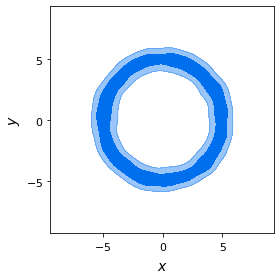

In [6]:
%matplotlib inline
from getdist import plots, MCSamples
import matplotlib.pyplot as plt

g = plots.get_single_plotter(width_inch=4, ratio=1)
sa = MCSamples(samples=rec_0.get().samples,
               names=['x', 'y'], labels=['x', 'y'])
g.plot_2d(sa, 'x', 'y', filled=True)

plt.show()